# Challenges

In this episode, we will provide two different challenges for you to attempt, based on the skills you have acquired so far. One of the challenges will be related to the shape of objects in images (morphometrics), while the other will be related to colors of objects in images (colorimetrics). We will not provide solution code for either of the challenges, but your instructors should be able to give you some gentle hints if you need them.

------


### Bacteria Colony Counting

As mentioned in the workshop _introduction_, 
your first final challenge is to determine how many bacteria colonies are in 
each of these images. As you already know, these images can be found in the 
**/data/** directory of the repository. 

![Colony image 1](../fig/00-colonies01.jpg)

![Colony image 2](../fig/00-colonies02.jpg)

![Colony image 3](../fig/00-colonies03.jpg)

Write a Python program that uses skimage to count the number of bacteria colonies in each image, and for each, produce a new image that labels the colonies. Your output should be similar to this image:

![colonies01 result](../fig/10-colonies01_overlay.png)

This time you won't get detailed instructions for every step. Instead, try to come up with a solution strategy yourself.

_Hint: You might want to use most of the analysis operations you already learned during the workshop, it's OK to copy code from preceding episodes!_

**Bonus Task:** Generate a histogram plot, which shows the colony size distributions. 

_Hint: This is a good opportunity to use the convenience Matplotlib `plt.hist()` function, [read the docs here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)._ 

In [ ]:
import skimage
import skimage.io
import skimage.filters
import numpy as np
import matplotlib.pyplot as plt                                                 
# 'magic' to display plots in the jupyter notebook                              
%matplotlib inline

# read the image data
col1 = skimage.io.imread('../data/colonies01.tif', as_gray = True)
col2 = skimage.io.imread('../data/colonies02.tif', as_gray = True)
col3 = skimage.io.imread('../data/colonies03.tif', as_gray = True)

# organize the data in a dictionary
dishes = {'Dish 1' : col1, 'Dish 2' : col2, 'Dish 3' : col3}

In [ ]:
# blurr the images
sigma = .7
blurred_dishes = {}
for name, image in dishes.items():
    blurred = skimage.filters.gaussian(image, sigma)
    blurred_dishes[name] = blurred

In [ ]:
# we need histograms again
def plot_histogram(image):                                                      
                                                                                
    histogram, bin_edges = np.histogram(image, bins = 256, range = (0,1))  
    
    plt.figure()
    plt.plot(bin_edges[:-1], histogram, color = 'k')                            
    

    plt.xlabel('Pixel value')                                                   
    plt.ylabel('Counts')                                                        
    plt.title('Grayscale Histogram')

In [ ]:
for name, image in blurred_dishes.items():
    plot_histogram(image)
    plt.title(name)

In [ ]:
# create the masks
# as in episode 07, the colonies are 
# at the far left end of the histogram

dish_masks = {}
thresh = 0.1
for name, image in blurred_dishes.items():
    mask = image < thresh
    dish_masks[name] = mask
    
    # generate plots for visual inspection
    plt.figure(figsize = (10,10))
    plt.imshow(mask, cmap = 'gray')
    plt.title(name)

In [ ]:
# run a CCA on the mask
from skimage.morphology import label
label_arrays = {}
for name, mask in dish_masks.items():
    
    label_arr = label(mask)
    label_arrays[name] = label_arr
    
    # generate plots for visual inspection
    plt.figure(figsize = (10,10))
    plt.imshow(label_arr, cmap = 'cividis')
    plt.title(name)

In [ ]:
# count the number of unique labels
# -> get the number of colonies
for name, label_arr in label_arrays.items():
    
    Ncolonies = len(np.unique(label_arr)) - 1
    print(f'{name} has {Ncolonies} colonies')


In [ ]:
# create the overlays
from skimage.color import label2rgb

for name in label_arrays.keys():
    image = blurred_dishes[name]
    label = label_arrays[name]
    
    # skimage.color.label2rgb takes bg_label = -1 as default, however 
    # skimage.morphology.label (CCA) returns bg_label = 0!
    overlay = label2rgb(label, image, alpha = 0.5, bg_label = 0)

    plt.figure(figsize = (10,10))
    plt.imshow(overlay)
    plt.title(name)

In [ ]:
# BONUS task solution
# Dish 1 yields no meaningful statistics..

# collection of sizes per dish
col_sizes = {}

for name, label_arr in label_arrays.items():
    
    # the sizes per colony
    sizes = []
    labels = np.unique(label_arr)
    
    # exclude first value -> background label
    for label in labels[1:]:
        size = np.sum(label_arr == label)
        sizes.append(size)
        
    col_sizes[name] = sizes


plt.figure(figsize = (8,4))
h = plt.hist(col_sizes.values(), density=True,
             label=col_sizes.keys(),
             range = (0,80), bins = 12,
            color = ['orchid','olive','orange'])
plt.legend()

### Colorimetrics: titration color analysis

The video showing the titration process first mentioned in the workshop 
_introduction_ episode can be found in the 
**/data/titration-movie** directory.
Write a Python program that uses skimage to analyze the video on a
frame-by-frame basis. Your program should do the following:

1. Sample a ROI from the same location on each frame, and determine the 
	average red, green, and blue channel value.

2. Display a graph plotting the average color channel values as a function of
	the frame number, similar to this image:

	![Titration colors](../fig/00-colorimetric-result.png)

3. Save the graph as an image named **titration.png**.

4. Output a CSV file named **titration.csv**, with each line containing
	the frame number, average red value, average green value, and average
	blue value
    
_Hint: The movie is given as an image sequence in `/data/titration-movie/image*.jpg`. Use `sorted( glob.glob(...) )` to crawl through the directory and read the images with `skimage.io`. Using a Pandas `DataFrame` to record the measurements might be a good idea, but no must._


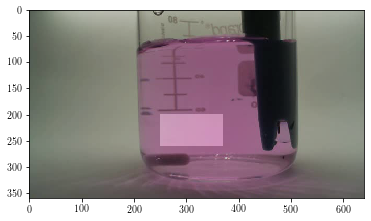

In [10]:
# read the one image to determine coordinates
import skimage.io
import skimage.draw
import numpy as np
from skimage.viewer import ImageViewer

import matplotlib.pyplot as plt                                                 
# 'magic' to display plots in the jupyter notebook                              
%matplotlib inline   

image = skimage.io.imread('../data/titration-movie/350-image.jpg')
# viewer = ImageViewer(image)
# viewer.show()

# select a rectangular ROI
r0, c0 = 200, 250
r1, c1 = 260, 370

rr, cc = skimage.draw.rectangle(start = (r0,c0), end = (r1,c1) )

# make sure we have the right spot
mask = np.zeros_like(image)
mask[rr,cc] = 255

plt.imshow(image)
plt.imshow(mask, alpha = 0.2)

In [21]:
# now load the image sequence and measure the three RGB channels
# save the recorded values into a pandas.DataFrame
from glob import glob
import pandas as pd

file_names = glob('../data/titration-movie/*image.jpg')
file_names = sorted(file_names)
Nframes = len(file_names)

df = pd.DataFrame(columns = ['red', 'green', 'blue'], index = range(Nframes))
rgb_to_ind = {'red' : 0, 'green' : 1, 'blue' : 2}

for i,name in enumerate(file_names):
    
    image = skimage.io.imread(name)
    
    for color, ind in rgb_to_ind.items():
        selection = image[rr,cc,ind]
        # mean intensity of that channel
        df.loc[i,color] = selection.mean()

In [22]:
# look at the nicely rendered DataFrame
df

,red,green,blue
0,194.232,189.312,177.646
1,194.381,189.333,177.558
2,194.369,189.408,177.737
3,194.537,189.308,177.663
4,194.392,189.298,177.725
...,...,...,...
531,192.87,121.145,167.711
532,192.809,121.232,167.589
533,193.106,121.18,167.622
534,192.969,121.083,167.918


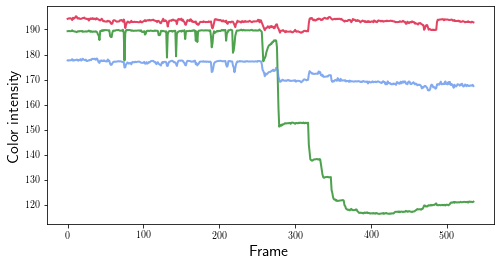

In [23]:
# now plot the result
plt.figure(figsize = (8,4))
plt.plot(df['red'], color = 'crimson', lw = 2, alpha = 0.8)
plt.plot(df['green'], color = 'forestgreen', lw = 2, alpha = 0.8)
plt.plot(df['blue'], color = 'cornflowerblue', lw = 2, alpha = 0.8)

plt.xlabel('Frame')
plt.ylabel('Color intensity')

plt.savefig('../fig/00-colorimetric-result.png')

In [24]:
# save output
df.to_csv('colorimetric-result.csv', sep = ',', index_label = 'frame')